<h1> <center> Trabajo Práctico Integrador </center> </h1>
<p> <FONT SIZE=4> <b> Alumno: </b> Lautaro Ochotorena </font> </p>
<p> <FONT SIZE=4> <b> DNI: </b> 41542924 </font> </p>
<p> <FONT SIZE=4> <b> Año: </b> 2022 </font> </p>
<p> <FONT SIZE=4> <b> Comisión: </b> 22039 </font> </p>
<center><img src ='img/portada.png'></center>

In [1]:
# A veces necesitamos instalar nuevas librerías en nuestros proyectos
!pip install --upgrade pip
!pip install openpyxl==3.0.10

In [2]:
# imports
import matplotlib.ticker as mtick #Este es para poder meter el signo $ de manera más fácil
import numpy as np
import pandas as pd
import sqlite3 as sql3
import openpyxl # para que levante bien el excel
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Paso 1: Alcances del proyecto y obtener datos</h2>
<h3>Alcances del proyecto</h3>
<p>En este proyecto vamos a integrar tres sets de datos con lista de vendedores, lista de artículos y registro de operaciones de un mes, que nos ayudarán a responder a las preguntas: </p>
<li>¿Cuál es el artículo más vendido? (unidades)</li>
<li>¿Qué artículo es el que más ingresos nos proporcionó?</li>
<li>¿A qué vendedor debe otorgarse el bono por "Mejor vendedor del mes"?</li>
<li>¿Hay grandes variaciones en ventas a lo largo del mes?</li>
<li>¿Mejores países compradores? (por monto). ¿Cuáles son los mejores 5?</li>
<li>Distribución de cantidad de los mejores 5 artículos vendidos en relación a los mejores 3 países</li>
<li>Variaciones de las ventas en el mes de los mejores 3 países</li>

</ul>
<p>Para este proyecto utilizaremos herramientas de Pandas para análisis exploratorio, Numpy para el análisis de ciertas columnas y Matplotlib/Seaborn para visualización de resultados.</p>
<h3>Descripción y obtención de los datos</h3>
<h4>Fuentes de datos</h4>
<ul>
<li>articles.db: BD con datos de los artículos.</li>
<li>sellers.xlsx: datos de los vendedores.</li>
<li>orders.csv: registro de las ventas de un mes.</li>
</ul>

In [3]:
# Levanto los datos en 3 diferentes dataframes

# Artículos
conn = sql3.connect('/work/data/articles.db')
sql_query = pd.read_sql_query('SELECT * FROM articles', conn)
df_articles = pd.DataFrame(sql_query, columns = ['article_id', 'article_name', 'unit_price'])

# Vendedores
df_sellers = pd.read_excel('/work/data/sellers.xlsx', index_col=0)

# Órdenes
df_orders = pd.read_csv('/work/data/orders.csv')


<h2>Paso 2: Explorar y preparar los datos</h2>
<h3>Exploración</h3>

In [4]:
# Exploración del df de artículos
print('Muestra de datos')
print(df_articles.head())
print('\nFormato del dataframe')
print(df_articles.shape)
print('\nBúsqueda de valores nulos por columna')
print(df_articles.isnull().sum())
print('\nFormato de los datos por columna')
print(df_articles.dtypes)


Muestra de datos
   article_id article_name unit_price
0       20015   Smartphone     525.00
1       20016      Full Pc    2127.81
2       20017      Monitor     230.00
3       20018       Tablet     130.00
4       20019         Desk     130.10

Formato del dataframe
(31, 3)

Búsqueda de valores nulos por columna
article_id      0
article_name    0
unit_price      0
dtype: int64

Formato de los datos por columna
article_id       int64
article_name    object
unit_price      object
dtype: object


In [5]:
# Exploración del df de vendedores
print('Muestra de datos')
print(df_sellers.head())
print('\nFormato del dataframe')
print(df_sellers.shape)
print('\nBúsqueda de valores nulos por columna')
print(df_sellers.isnull().sum())
print('\nFormato de los datos por columna')
print(df_sellers.dtypes)

Muestra de datos
                 seller_name
seller_id                   
1           Aveline Swanwick
2                   Jase Doy
3          Oliviero Charkham
4           Cornie Wynrehame
5                Ewell Peres

Formato del dataframe
(15, 1)

Búsqueda de valores nulos por columna
seller_name    0
dtype: int64

Formato de los datos por columna
seller_name    object
dtype: object


In [6]:
# Exploración del df de órdenes
print('Muestra de datos')
print(df_orders.head())
print('\nFormato del dataframe')
print(df_orders.shape)
print('\nBúsqueda de valores nulos por columna')
print(df_orders.isnull().sum())
print('\nFormato de los datos por columna')
print(df_orders.dtypes)

Muestra de datos
   order_id  week  article_id  quantity  seller_id country_name
0     15024     1       20039        10         10         Peru
1     15025     1       20029        15          5         Peru
2     15026     1       20024         5         14      Bolivia
3     15027     1       20018         9         14       Brazil
4     15028     1       20035         6         15       Mexico

Formato del dataframe
(1000, 6)

Búsqueda de valores nulos por columna
order_id        0
week            0
article_id      0
quantity        0
seller_id       0
country_name    0
dtype: int64

Formato de los datos por columna
order_id         int64
week             int64
article_id       int64
quantity         int64
seller_id        int64
country_name    object
dtype: object


<h3>Preparación</h3>
<p>Encuentro un inconveniente en la columna de precios de los artículos. Necesito cambiar el formato cadena a float.</p>

In [7]:
df_articles['unit_price'] = df_articles['unit_price'].astype(float)
print(df_articles.dtypes)

article_id        int64
article_name     object
unit_price      float64
dtype: object


<h2>Paso 3: Definir el modelo de datos</h2>
<p>Crearemos un nuevo dataframe a partir de las fuentes de datos proporcionados.</p>
<img src='/work/img/modelo.png'>


<h2>Paso 4: Correr los pipelines para modelar los datos</h2>
<p>Llamamos pipeline a una serie de procesos en el cual la salida de un proceso es la entrada que utiliza el siguiente proceso.</p>

In [8]:
# Creo una copia del df_orders
my_df = df_orders.copy()

# Cambio el índice del df de artículos
df_articles.set_index('article_id',inplace = True)

# Agrego algunas columnas y pongo el campo que me va a servir de "ancla" para acordarme
my_df = my_df.assign(article_name = my_df['article_id'])
my_df = my_df.assign(total_amount = my_df['article_id'])
my_df = my_df.assign(seller_name = my_df['seller_id'])


# reemplazo los valores en el nuevo df

# 1. busco el nombre del artículo y lo asigno a una variable
    # como df_articles está indexado por article_id, lo uso para ubicarme en 
    # el registro que busco
    # SINTAXIS: df_articles.loc[indice][columna]
    # [indice] va a ser el dato que obtengo de my_df.loc[i]['article_id']
    # -> o sea, tomo registro a registro el article_id y lo uso para extraer 
    # el nombre del artículo

for i in range(len(my_df.index)): # len(my_df.index) devuelve la cantidad de registros
    
    idArticulo = my_df.loc[i]['article_id']
    nombreArticulo = df_articles.loc[idArticulo]['article_name']

    # se lo asigno a la columna correspondiente
    my_df.loc[i,'article_name'] = nombreArticulo

    # hago lo mismo en un solo paso para la columna de total_amount
    precioArticulo = df_articles.loc[idArticulo]['unit_price']
    cantArticulo = my_df.loc[i]['quantity']
    my_df.loc[i,'total_amount'] = precioArticulo * cantArticulo

    # columna de seller_name
    idVendedor = my_df.loc[i]['seller_id']
    nombreVendedor = df_sellers.loc[idVendedor]['seller_name']
    my_df.loc[i,'seller_name'] = nombreVendedor

# elimino las columnas que no necesito
my_df.drop(['order_id', 'article_id', 'seller_id'],  axis = 'columns', inplace=True)
print(my_df)

     week  quantity country_name   article_name  total_amount      seller_name
0       1        10         Peru  Water Cooling         675.0  Cirilo Grandham
1       1        15         Peru          Mouse         454.5      Ewell Peres
2       1         5      Bolivia        Netbook         725.0   Janel O'Curran
3       1         9       Brazil         Tablet        1170.0   Janel O'Curran
4       1         6       Mexico           Case         227.4  Daisie Slograve
..    ...       ...          ...            ...           ...              ...
995     4         1       Brazil          Modem          67.5       Kati Innot
996     4        15       Brazil       Heatsink         150.0  Daisie Slograve
997     4         2     Colombia       Heatsink          20.0  Vasily Danilyuk
998     4        14       Brazil         Tablet        1820.0  Vasily Danilyuk
999     4        12       Brazil            SDD         264.0     Onida Cosely

[1000 rows x 6 columns]


In [9]:
# SI SOBRA TIEMPO Se puede mencionar la función merge para hacer joins entre dataframes
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
d1=pd.DataFrame({'mes': ['ene','feb','mar','abr'], 'ventas':[10,20,30,15]})
d2=pd.DataFrame({'mes': ['ene','feb','mar','abr'], 'costos':[7,16,25,12]})
print(pd.merge(d1,d2))

   mes  ventas  costos
0  ene      10       7
1  feb      20      16
2  mar      30      25
3  abr      15      12


<h2>Paso 5: Responder las preguntas</h2>


<h3>1. ¿Cuál es el artículo más vendido? (en unidades)</h3>

In [10]:
# RESOLUCIÓN ANALÍTICA
my_df2=my_df.groupby('article_name').sum()
por_cant = my_df2.sort_values('quantity',  ascending=False)
print(por_cant['quantity'].head(1))


article_name
HDD    413
Name: quantity, dtype: int64


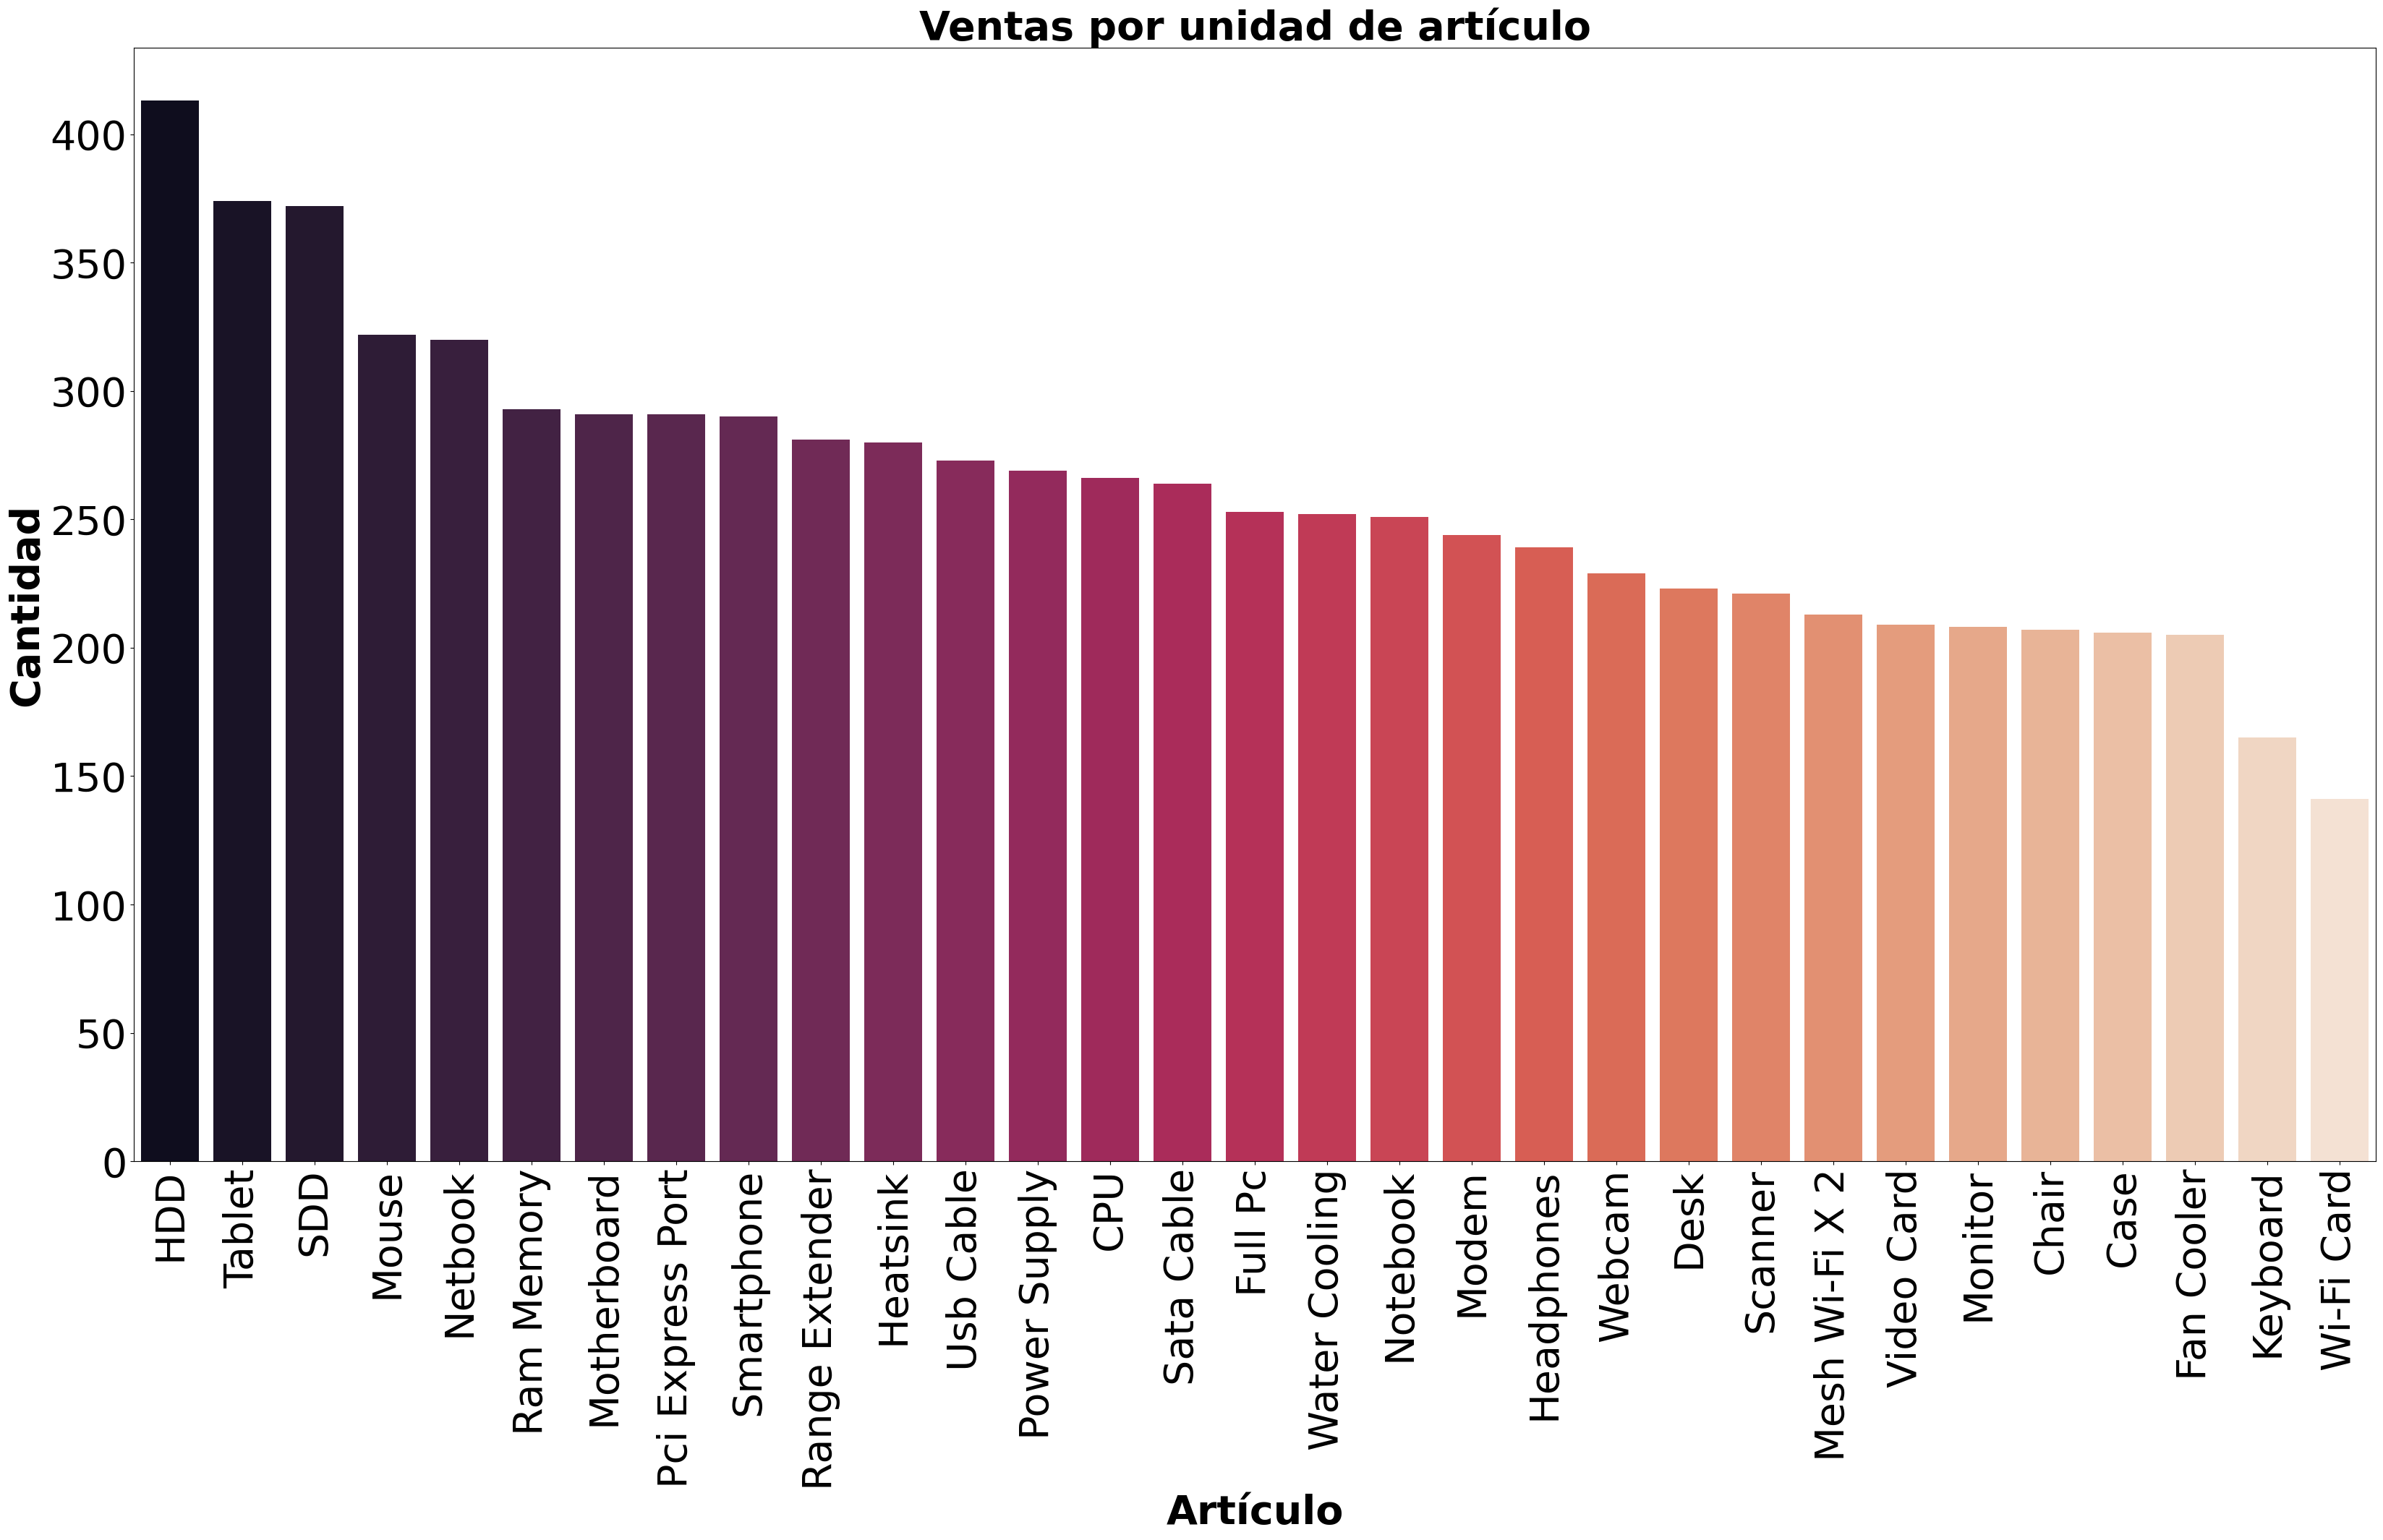

In [11]:
# RESOLUCIÓN GRÁFICA
fig, ax = plt.subplots(figsize=(40,20))
sns.barplot(y=por_cant["quantity"], x=por_cant.index, palette = 'rocket', ax=ax)
plt.xticks(rotation=90)

#labels
plt.xlabel('Artículo', fontsize=40, fontweight='bold')
plt.ylabel('Cantidad', fontsize=40, fontweight='bold')

#Agrandar
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

#Título
plt.title('Ventas por unidad de artículo', fontsize=40, fontweight='bold')

plt.show()


<h3>2. ¿Qué artículo es el que más ingresos nos proporcionó?</h3>

In [12]:
# RESOLUCIÓN ANALÍTICA
df2 = (my_df.groupby(by='article_name').sum()).sort_values('total_amount',ascending=False).head(5)
print(df2['total_amount'])


article_name
Full Pc       538335.93
Notebook      251000.00
Smartphone    152250.00
Chair          69477.48
Tablet         48620.00
Name: total_amount, dtype: float64


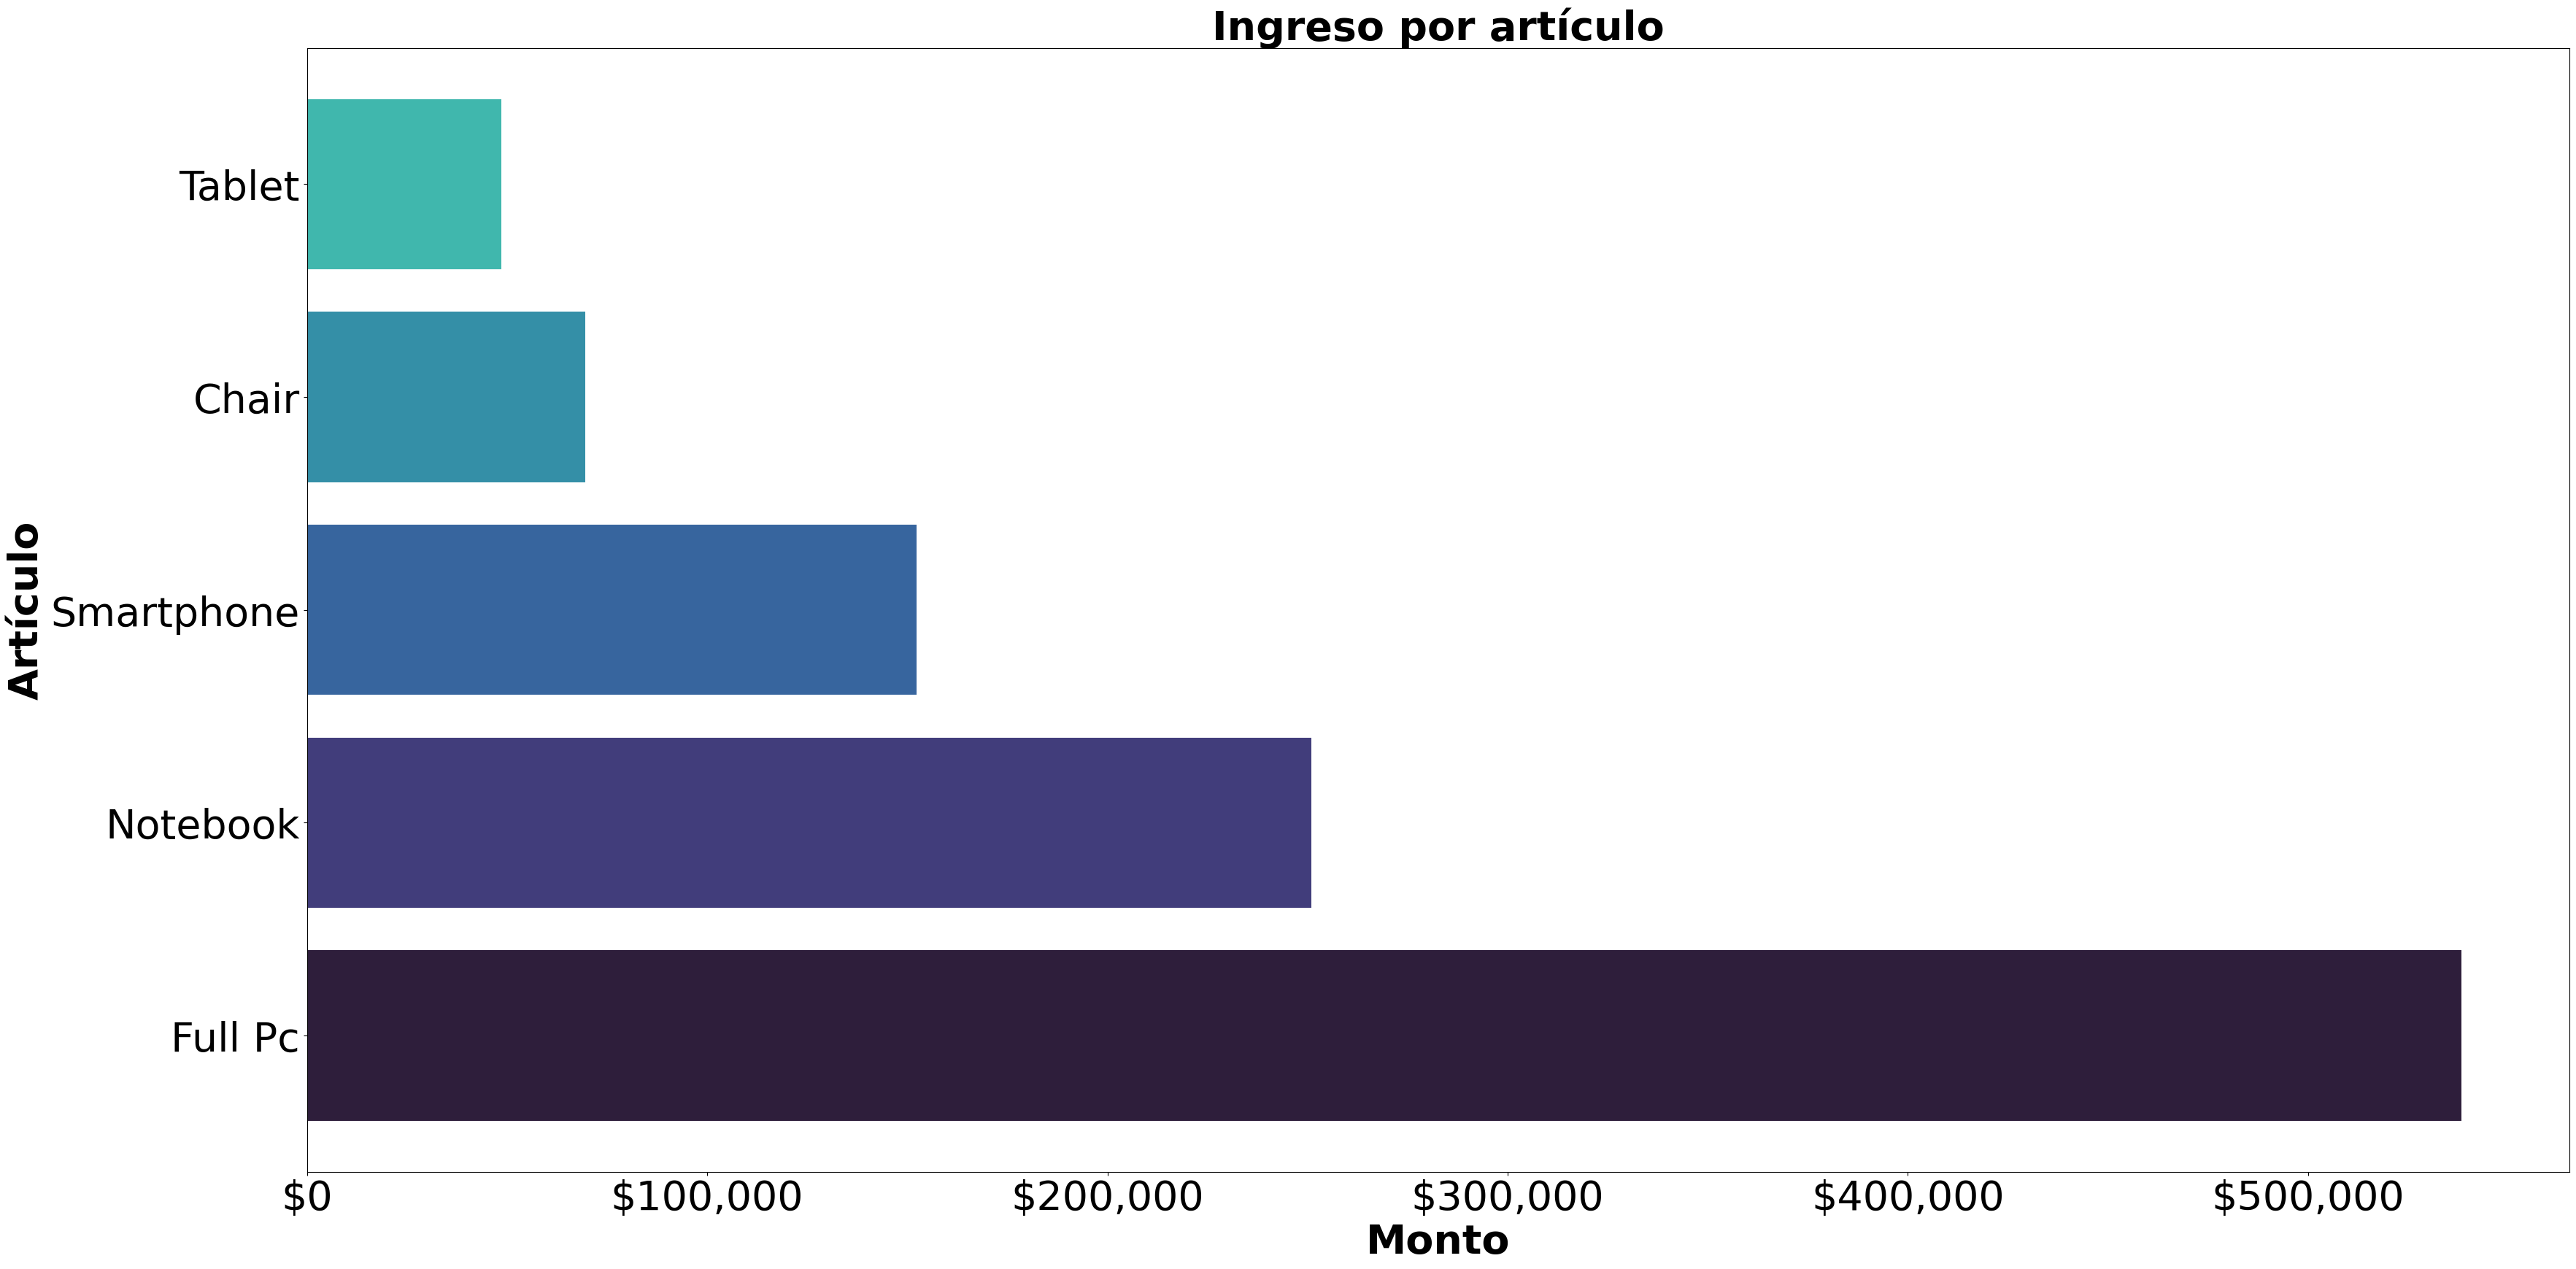

In [13]:
# RESOLUCIÓN GRÁFICA  
#En el caso de utilizar gráfico de torta ---> OJO: Voy a tomar sólo los 5 primeros artículos que más ingresos proporcionaron
# No puedo hacer una comparativa ni porcentajes porque no tomé el total de los datos
#plt.pie(x=df2['total_amount'], labels=df2.index)
#plt.show()
fig, ax = plt.subplots(figsize=(40,20))
colors = sns.color_palette('mako') #Color de las barras
plt.barh(df2.index,df2['total_amount'] , height=0.8, color = colors)

#labels
plt.xlabel('Monto', fontsize=40, fontweight='bold')
plt.ylabel('Artículo', fontsize=40, fontweight='bold')

#Agrandar
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

#Título
plt.title('Ingreso por artículo', fontsize=40, fontweight='bold')

#Setear el signo $ en el eje X
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 

plt.show()

<h3>3. ¿A qué vendedor debe otorgarse el bono por "Mejor vendedor del mes"?</h3>

In [14]:
# RESOLUCIÓN ANALÍTICA
df4 = (my_df.groupby(by='seller_name').sum()).sort_values('total_amount',ascending=False)
print(df4[['quantity']+['total_amount']])

                   quantity  total_amount
seller_name                              
Janel O'Curran          703     192832.47
Brockie Patience        441     142709.88
Oliviero Charkham       555     141329.76
Vasily Danilyuk         521     129157.55
Daisie Slograve         554     120520.11
Aveline Swanwick        629     118874.33
Arnold Kilkenny         583      94552.04
Kati Innot              512      83704.62
Jase Doy                582      80628.31
Ewell Peres             496      78144.32
Onida Cosely            535      77373.37
Milly Christoffe        442      61733.69
Tobin Roselli           519      56984.42
Cornie Wynrehame        523      52253.57
Cirilo Grandham         470      45009.40


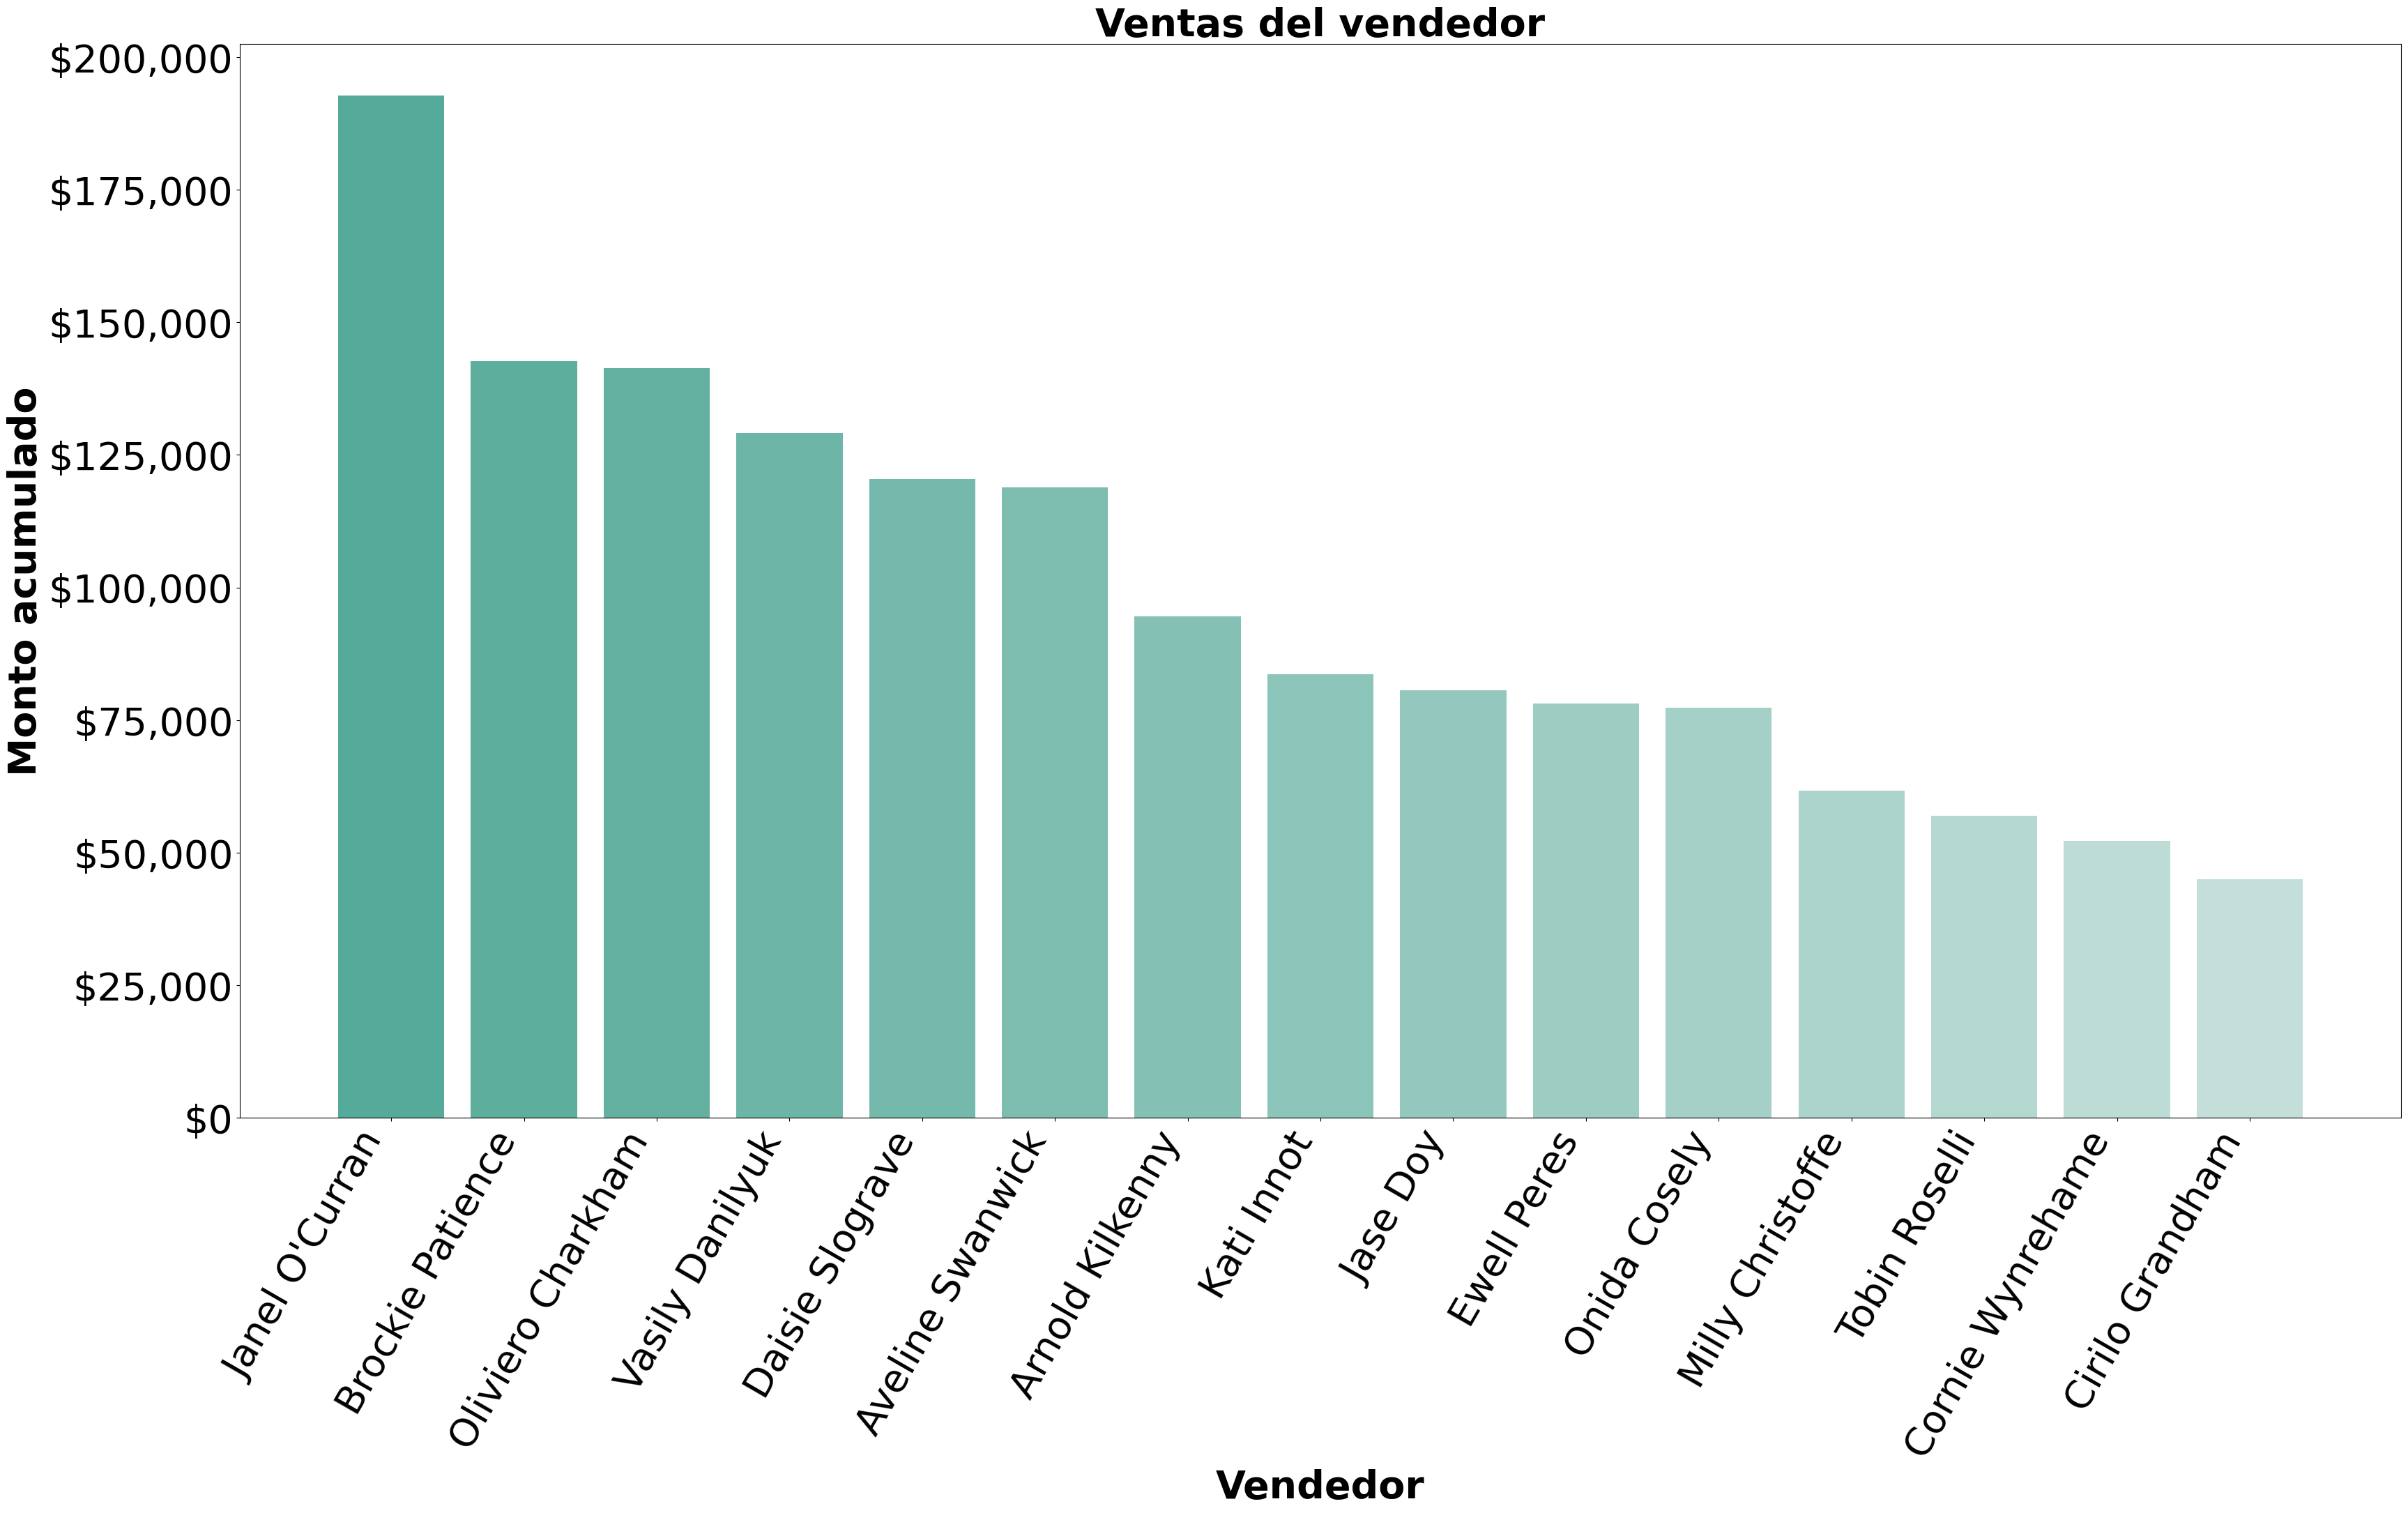

In [15]:
# RESOLUCIÓN GRÁFICA
fig, ax = plt.subplots(figsize=(40,20))
colors = sns.color_palette("light:#5A9", 20) #Color de las barras
colors.reverse() #Da vuelta la lista del degradado
plt.bar(df4.index,df4['total_amount'], color=colors)
plt.xticks(rotation=60, ha="right")

#labels
plt.xlabel('Vendedor', fontsize=40, fontweight='bold')
plt.ylabel('Monto acumulado', fontsize=40, fontweight='bold')

#Agrandar
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

#Título
plt.title('Ventas del vendedor', fontsize=40, fontweight='bold')

#Setear el signo $ en el eje Y
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.show()

<h3>4. ¿Hay grandes variaciones en ventas a lo largo del mes?</h3>
<h4>Si es así, ¿en qué momento debería lanzar una campaña de promociones?</h4>


In [16]:
# RESOLUCIÓN ANALÍTICA
df5 = (my_df.groupby(by='week').sum()).sort_values('total_amount',ascending=False)
print(df5['total_amount'])


week
1    507458.81
2    415364.44
3    329140.03
4    223844.56
Name: total_amount, dtype: float64


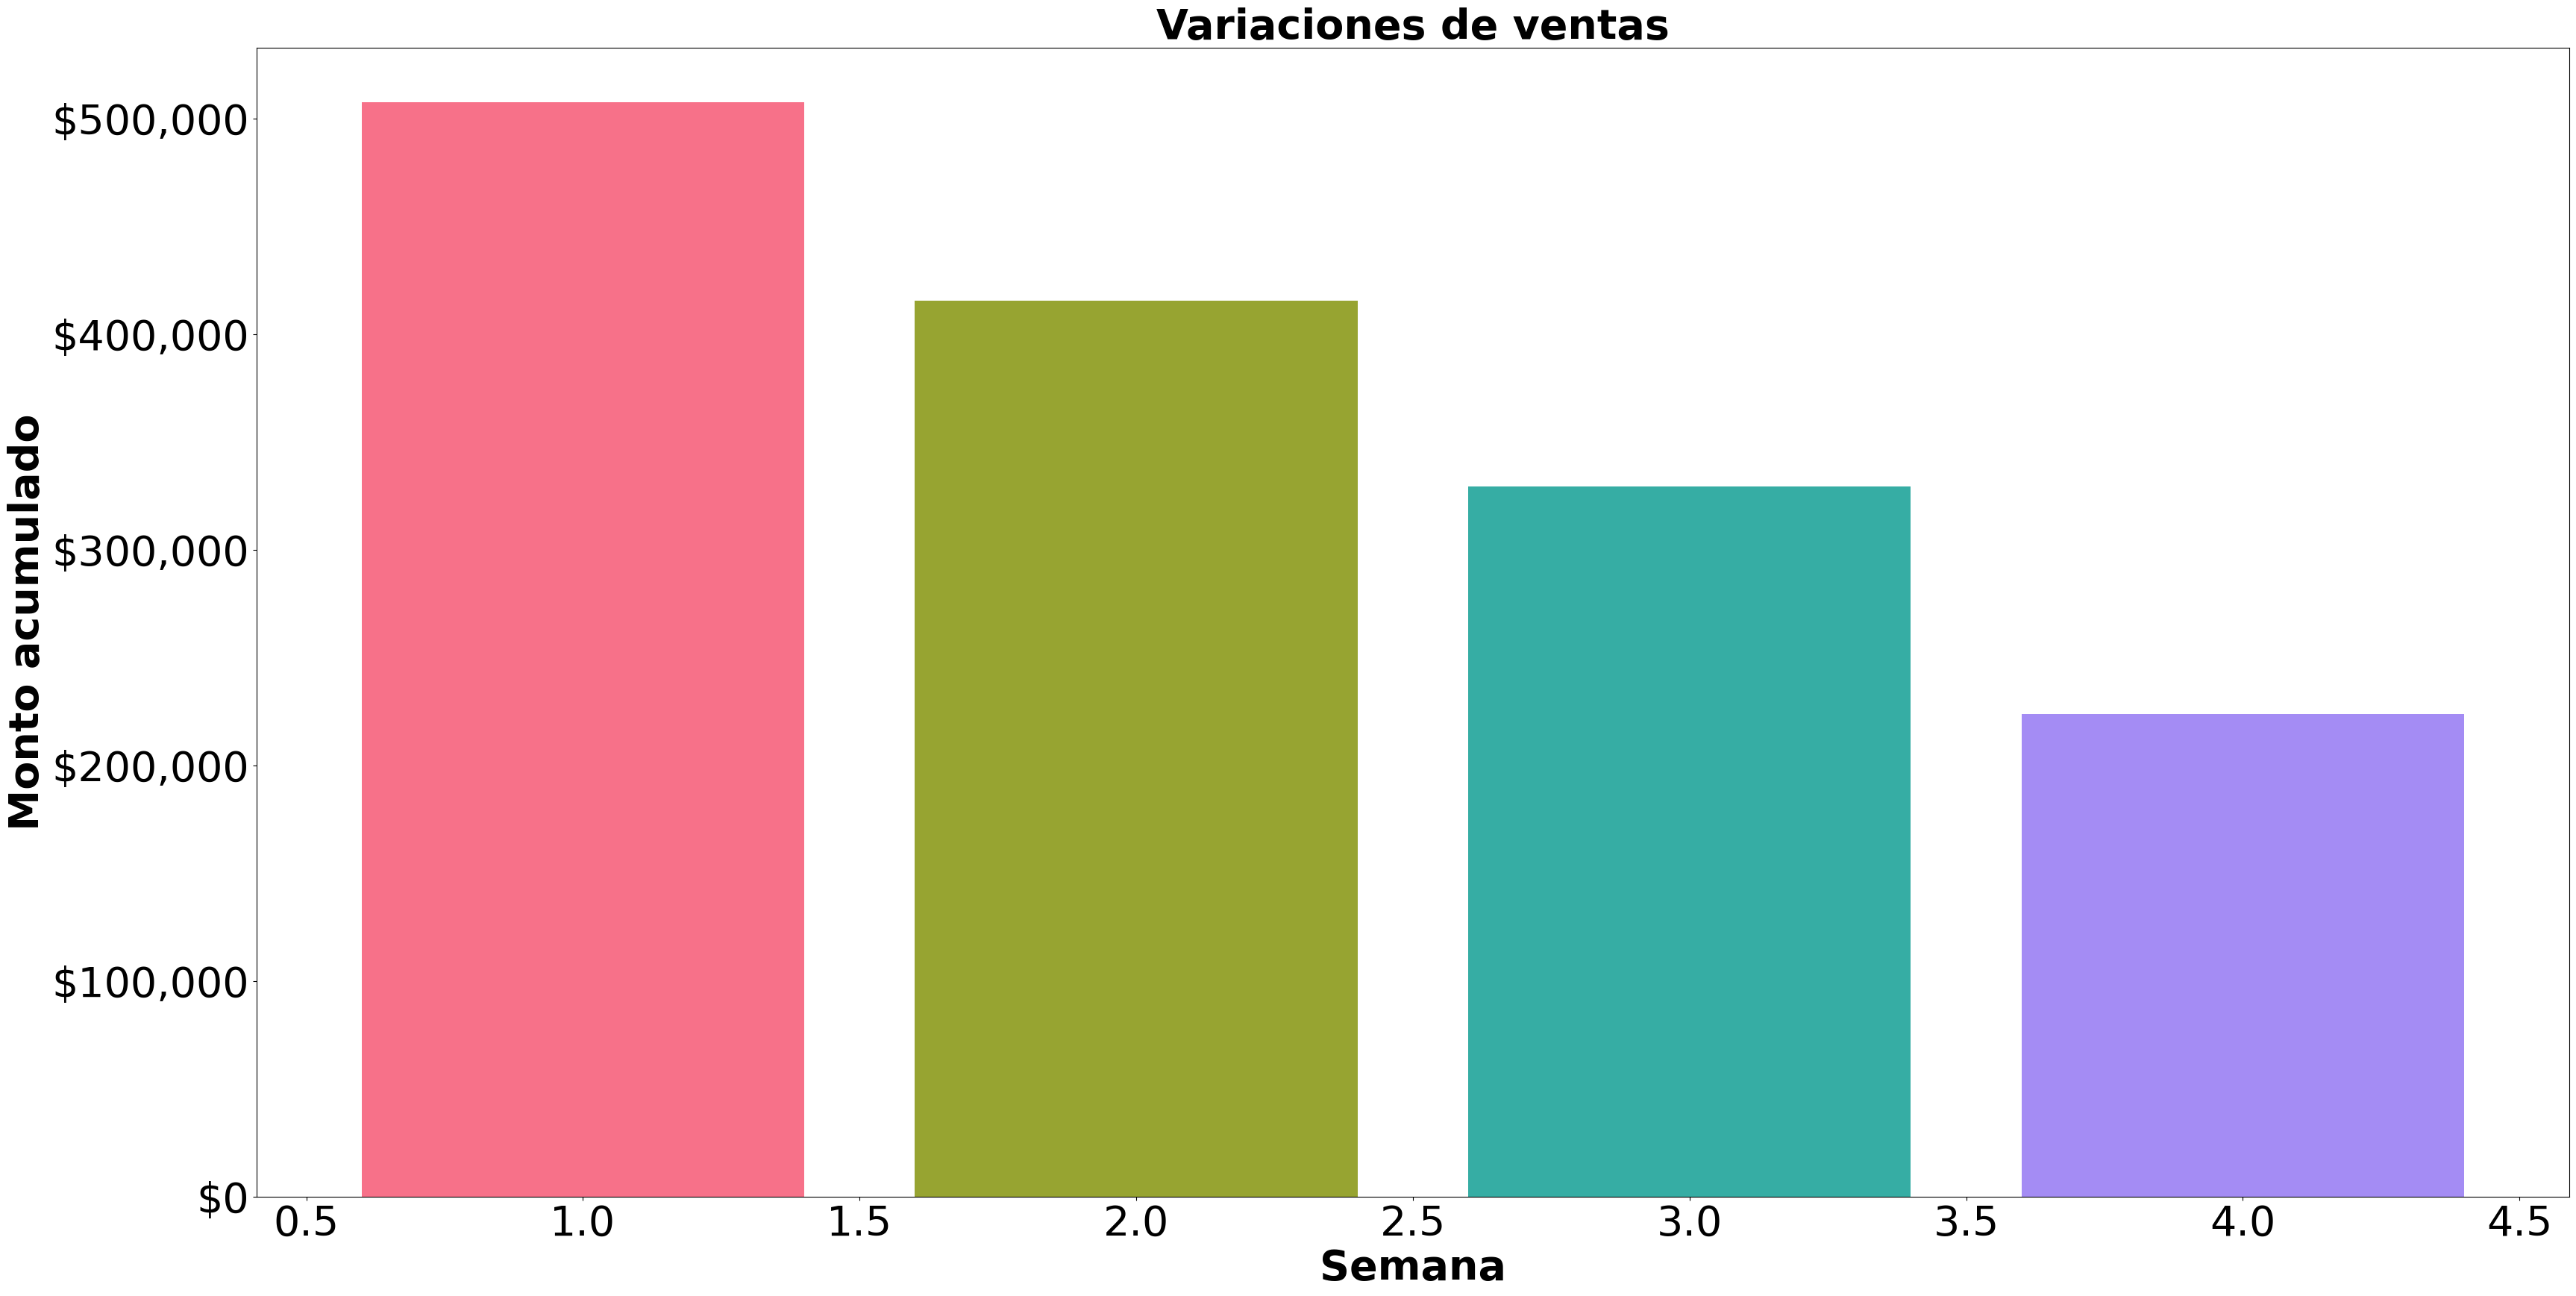

In [17]:
# RESOLUCIÓN GRÁFICA
fig, ax = plt.subplots(figsize=(40,20))
colors = sns.color_palette("husl", 4)
plt.bar(df5.index,df5['total_amount'], color=colors)

#labels
plt.xlabel('Semana', fontsize=40, fontweight='bold')
plt.ylabel('Monto acumulado', fontsize=40, fontweight='bold')

#Agrandar
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

#Setear el signo $ en el eje Y
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

 #Título
plt.title('Variaciones de ventas', fontsize=40, fontweight='bold')

plt.show()

<h2>Tareas a realizar</h2>
<ul>
<li>Pensar 3 preguntas y responderlas con el método que consideres más apropiado. Al menos una de ellas debe contener la columna 'country_name' y al menos una de ellas debe buscar correlación entre dos variables categóricas.</li>
<li>Personalizar, estilar y dar contexto a las gráficas.</li>
<li>Generar un informe en el que se responda en forma coloquial a las preguntas, agregando conclusiones y consejos que puedan surgir de este trabajo. Se pueden agregar imágenes.</li>
<li>Publicar el trabajo y concretar la entrega en <a href="https://docs.google.com/forms/d/e/1FAIpQLSdiu_l6aO4tKBLiojZJp-RLF--deRAW0VM-0eqQ9tHJSD-j7A/viewform">https://docs.google.com/forms/d/e/1FAIpQLSdiu_l6aO4tKBLiojZJp-RLF--deRAW0VM-0eqQ9tHJSD-j7A/viewform</a>. <br>Deberás proporcionar link al notebook fuente y a la publicación. <br>Video/guía de cómo entregar el trabajo: <a href="https://youtu.be/FCQRhs4dxls">https://youtu.be/FCQRhs4dxls</a></li>
<li>Entregas:  4 de julio hasta 15 de julio, 2022 - 23:59 hs</li>
</ul>

<h3>5. ¿Mejores países compradores? (por monto). ¿Cuáles son los mejores 5?</h3>

In [18]:
#Resolución analítica
df6 = my_df.groupby('country_name').sum().sort_values('total_amount', ascending=False) #Agrupo por País, sumo y ordeno de manera ascendiente
df6 = df6.drop(columns=['week', 'quantity']) #Elimino las columnas que no me sirven
print(df6)

              total_amount
country_name              
Brazil           441271.85
Argentina        205832.78
Colombia         177514.29
Peru             161421.12
Mexico           138619.99
Venezuela         77684.52
El Salvador       57391.26
Guatemala         52579.25
Honduras          36763.56
Costa Rica        34606.50
Chile             24660.98
Bolivia           22682.80
Uruguay           17843.09
Ecuador           17475.30
Paraguay           8195.12
Puerto Rico        1265.43


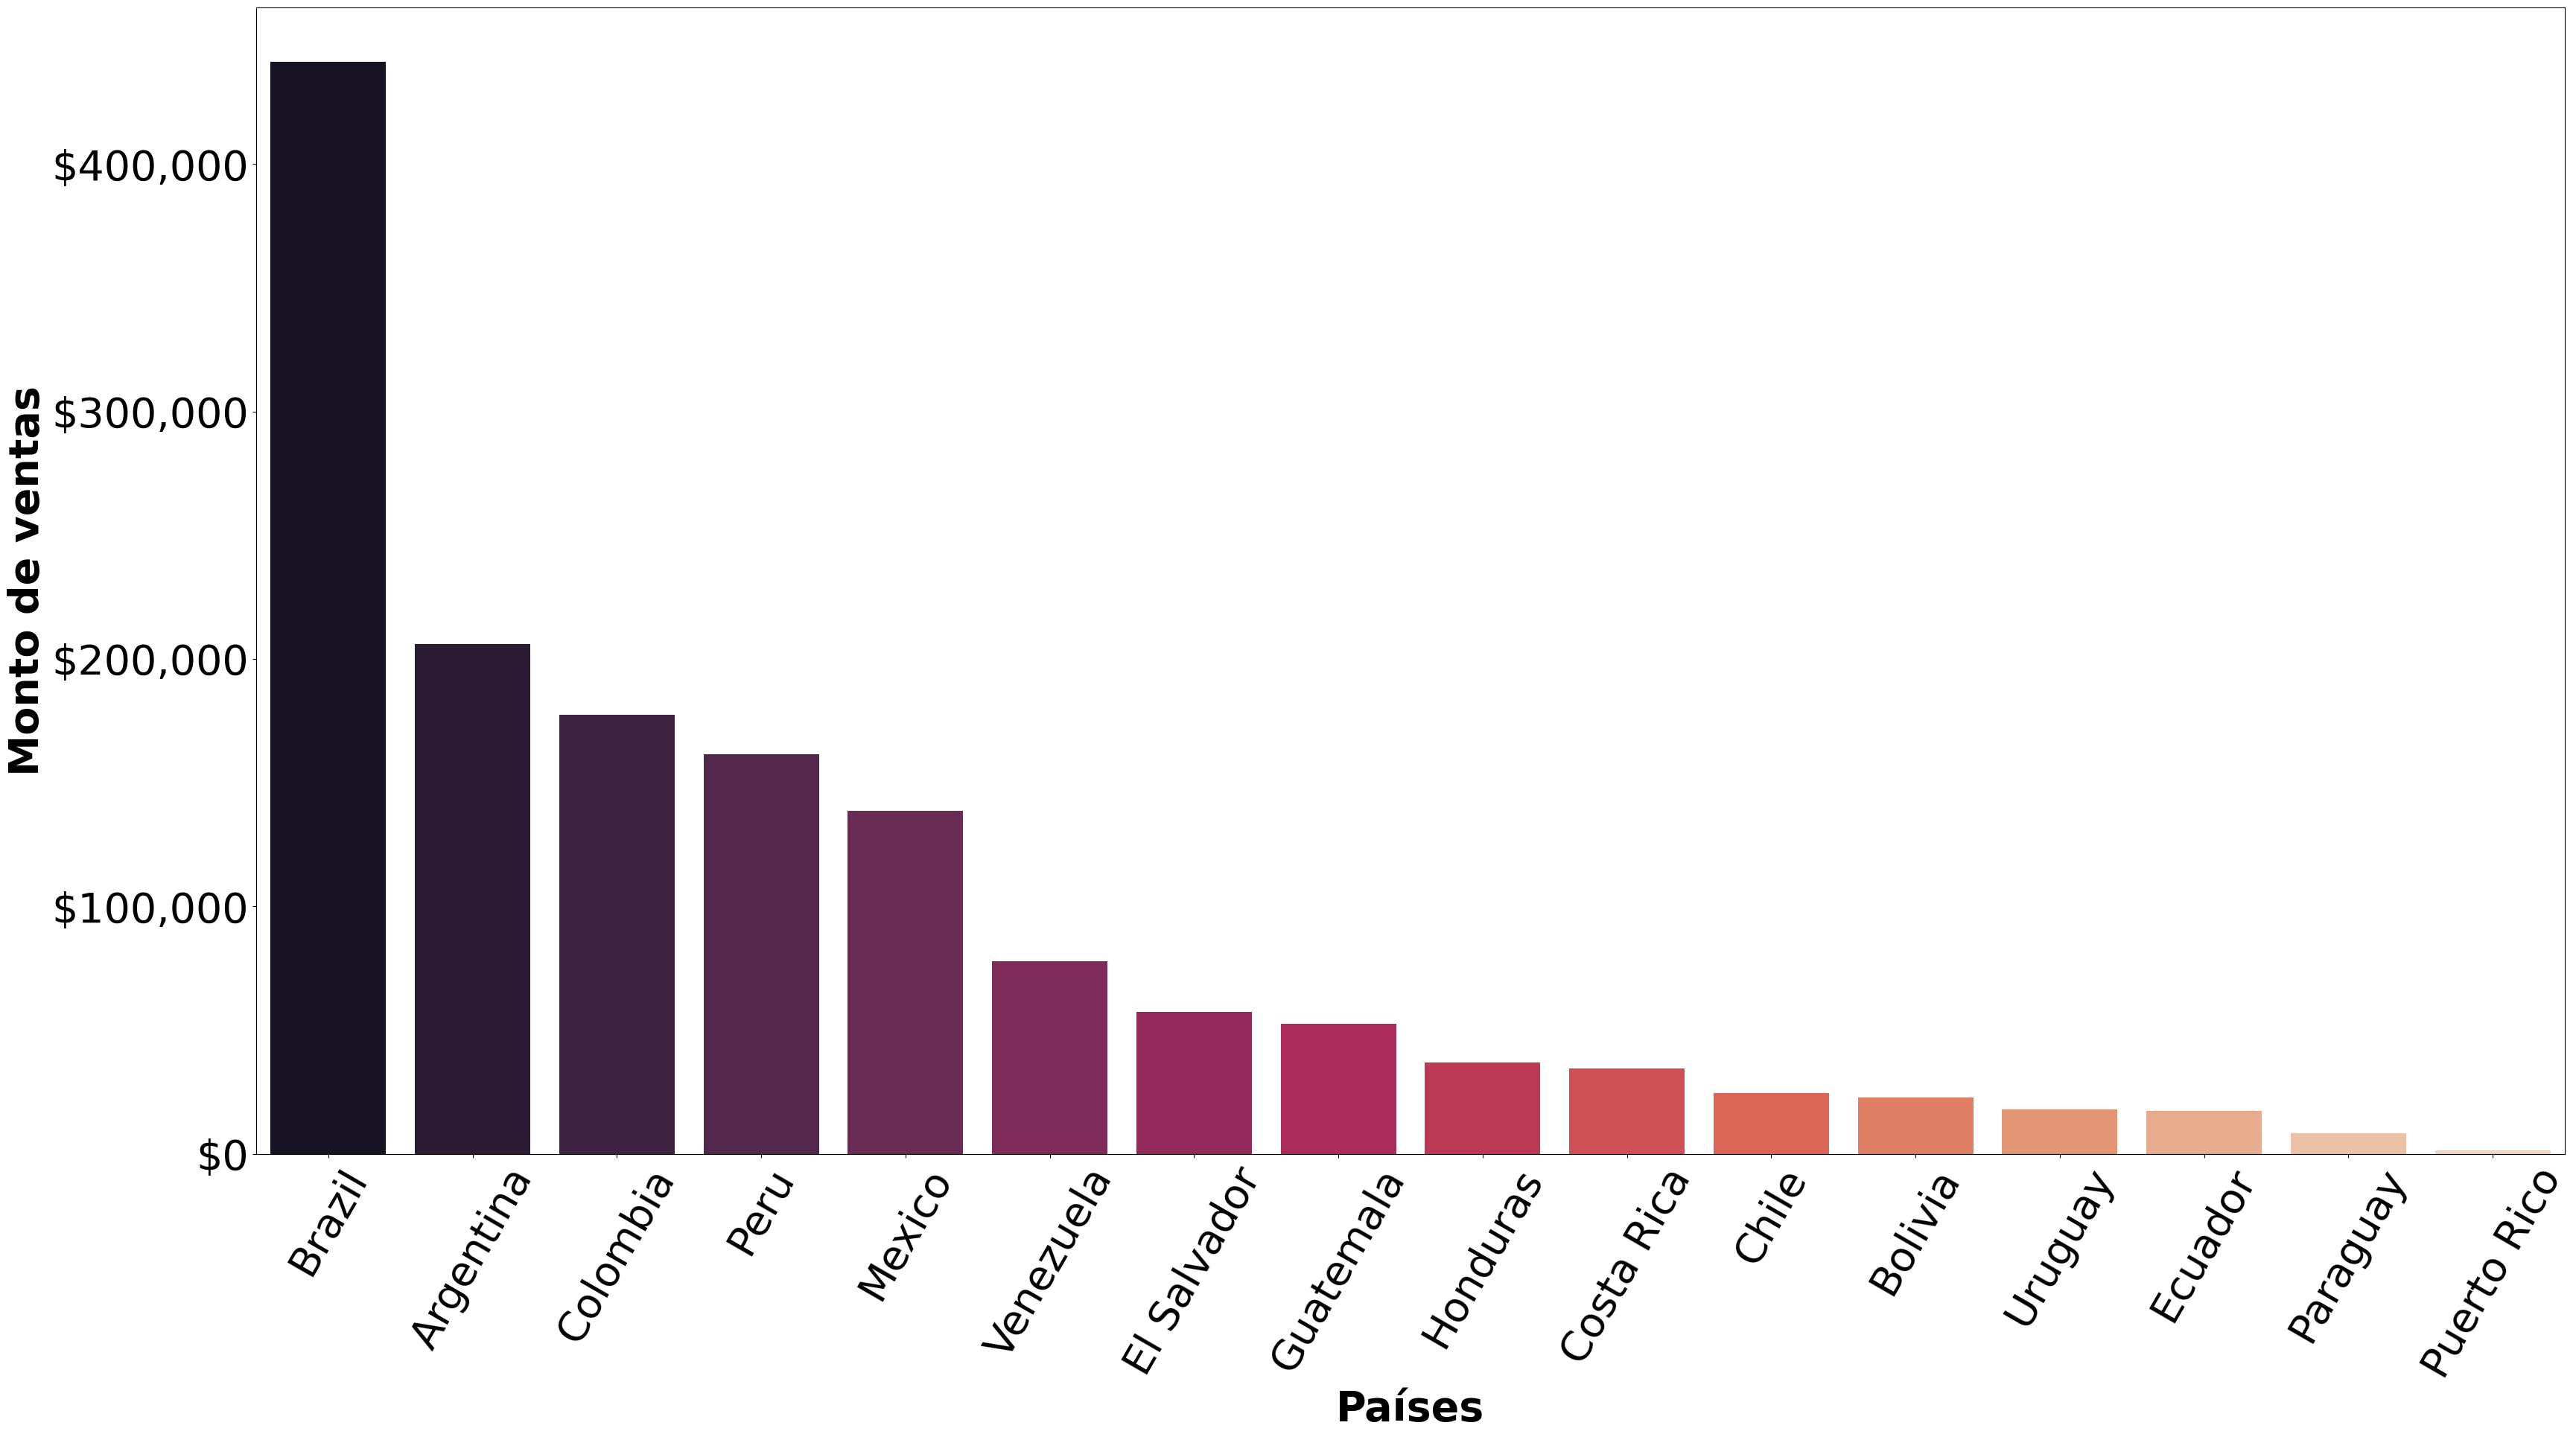

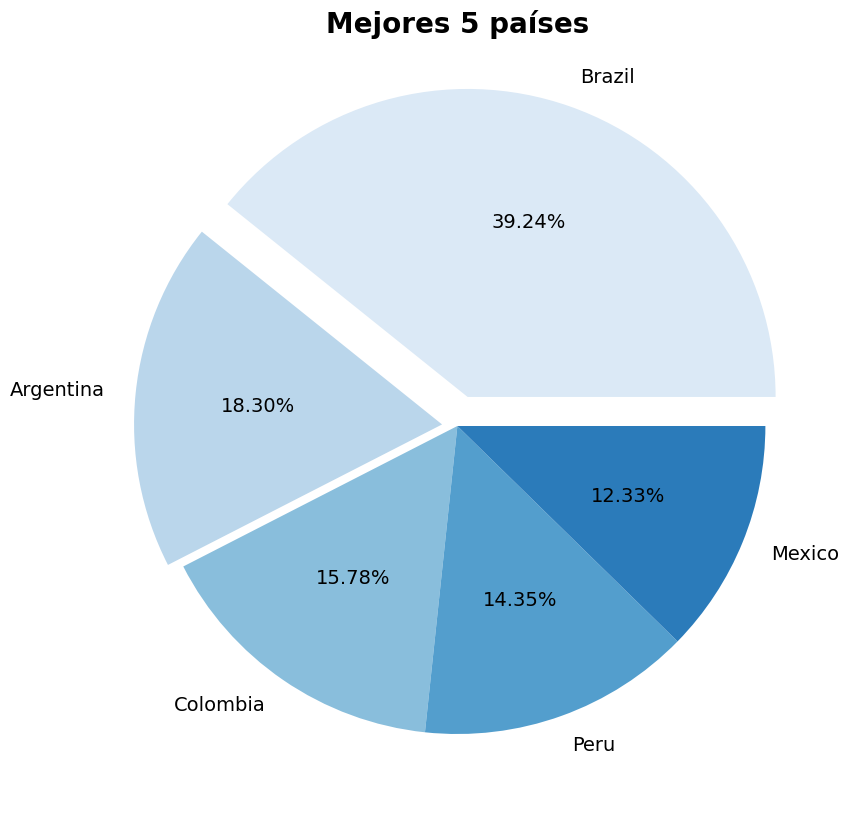

In [19]:
#Resolución gráfica
#Distribución de mejores países
fig, ax = plt.subplots(figsize=(40,20))
sns.barplot(x=df6.index,y=df6['total_amount'], palette = 'rocket', ax=ax)

#Setear el signo $ en el eje Y
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#Rotación de los nombres del eje X
plt.xticks(rotation=60)

#Labels
plt.xlabel('Países', fontsize=40, fontweight='bold')
plt.ylabel('Monto de ventas', fontsize=40, fontweight='bold')

#Agrandar
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

plt.show()

#Haré otro gráfico, uno de torta para los mejores 5 (el porcentaje no considera el total de países)

colors = sns.color_palette('Blues')[0:5] #Paleta de colores
fig, ax = plt.subplots(figsize=(15,10))
e = (0.1, 0.05, 0 , 0 , 0) #Explote una parte del gráfico
plt.pie(df6.head()['total_amount'], labels=df6.head().index, explode = e, autopct='%1.2f%%', colors = colors, textprops={'fontsize': 14})
plt.title('Mejores 5 países', fontsize=20, fontweight='bold') #Título
plt.show()

<h3>6. Distribución de cantidad de los mejores 5 artículos vendidos en relación a los mejores 3 países </h3>

In [20]:
# Resolución analítica
df7 = my_df.copy() #Copia del dataframe original

países = df6.head(3).index.values #Mejores 3 países
artículos = df2.head().index.values #Mejores 5 artículos

#Hay que eliminar las filas que no contengan ni estos países ni estos artículos
for i in range(len(df7.index)):
    if (df7.loc[i, 'country_name'] not in países) or (df7.loc[i, 'article_name'] not in artículos):
        df7 = df7.drop([i])
        
#Elimino columnos que no me aportan para este análisis
df7 = df7.drop(columns=['week','total_amount','seller_name'])
print(df7)

     quantity country_name article_name
3           9       Brazil       Tablet
16          6       Brazil      Full Pc
20         10     Colombia       Tablet
38          2       Brazil      Full Pc
60         15       Brazil        Chair
..        ...          ...          ...
956        11       Brazil        Chair
985        10       Brazil       Tablet
988        13     Colombia      Full Pc
993         8       Brazil        Chair
998        14       Brazil       Tablet

[91 rows x 3 columns]


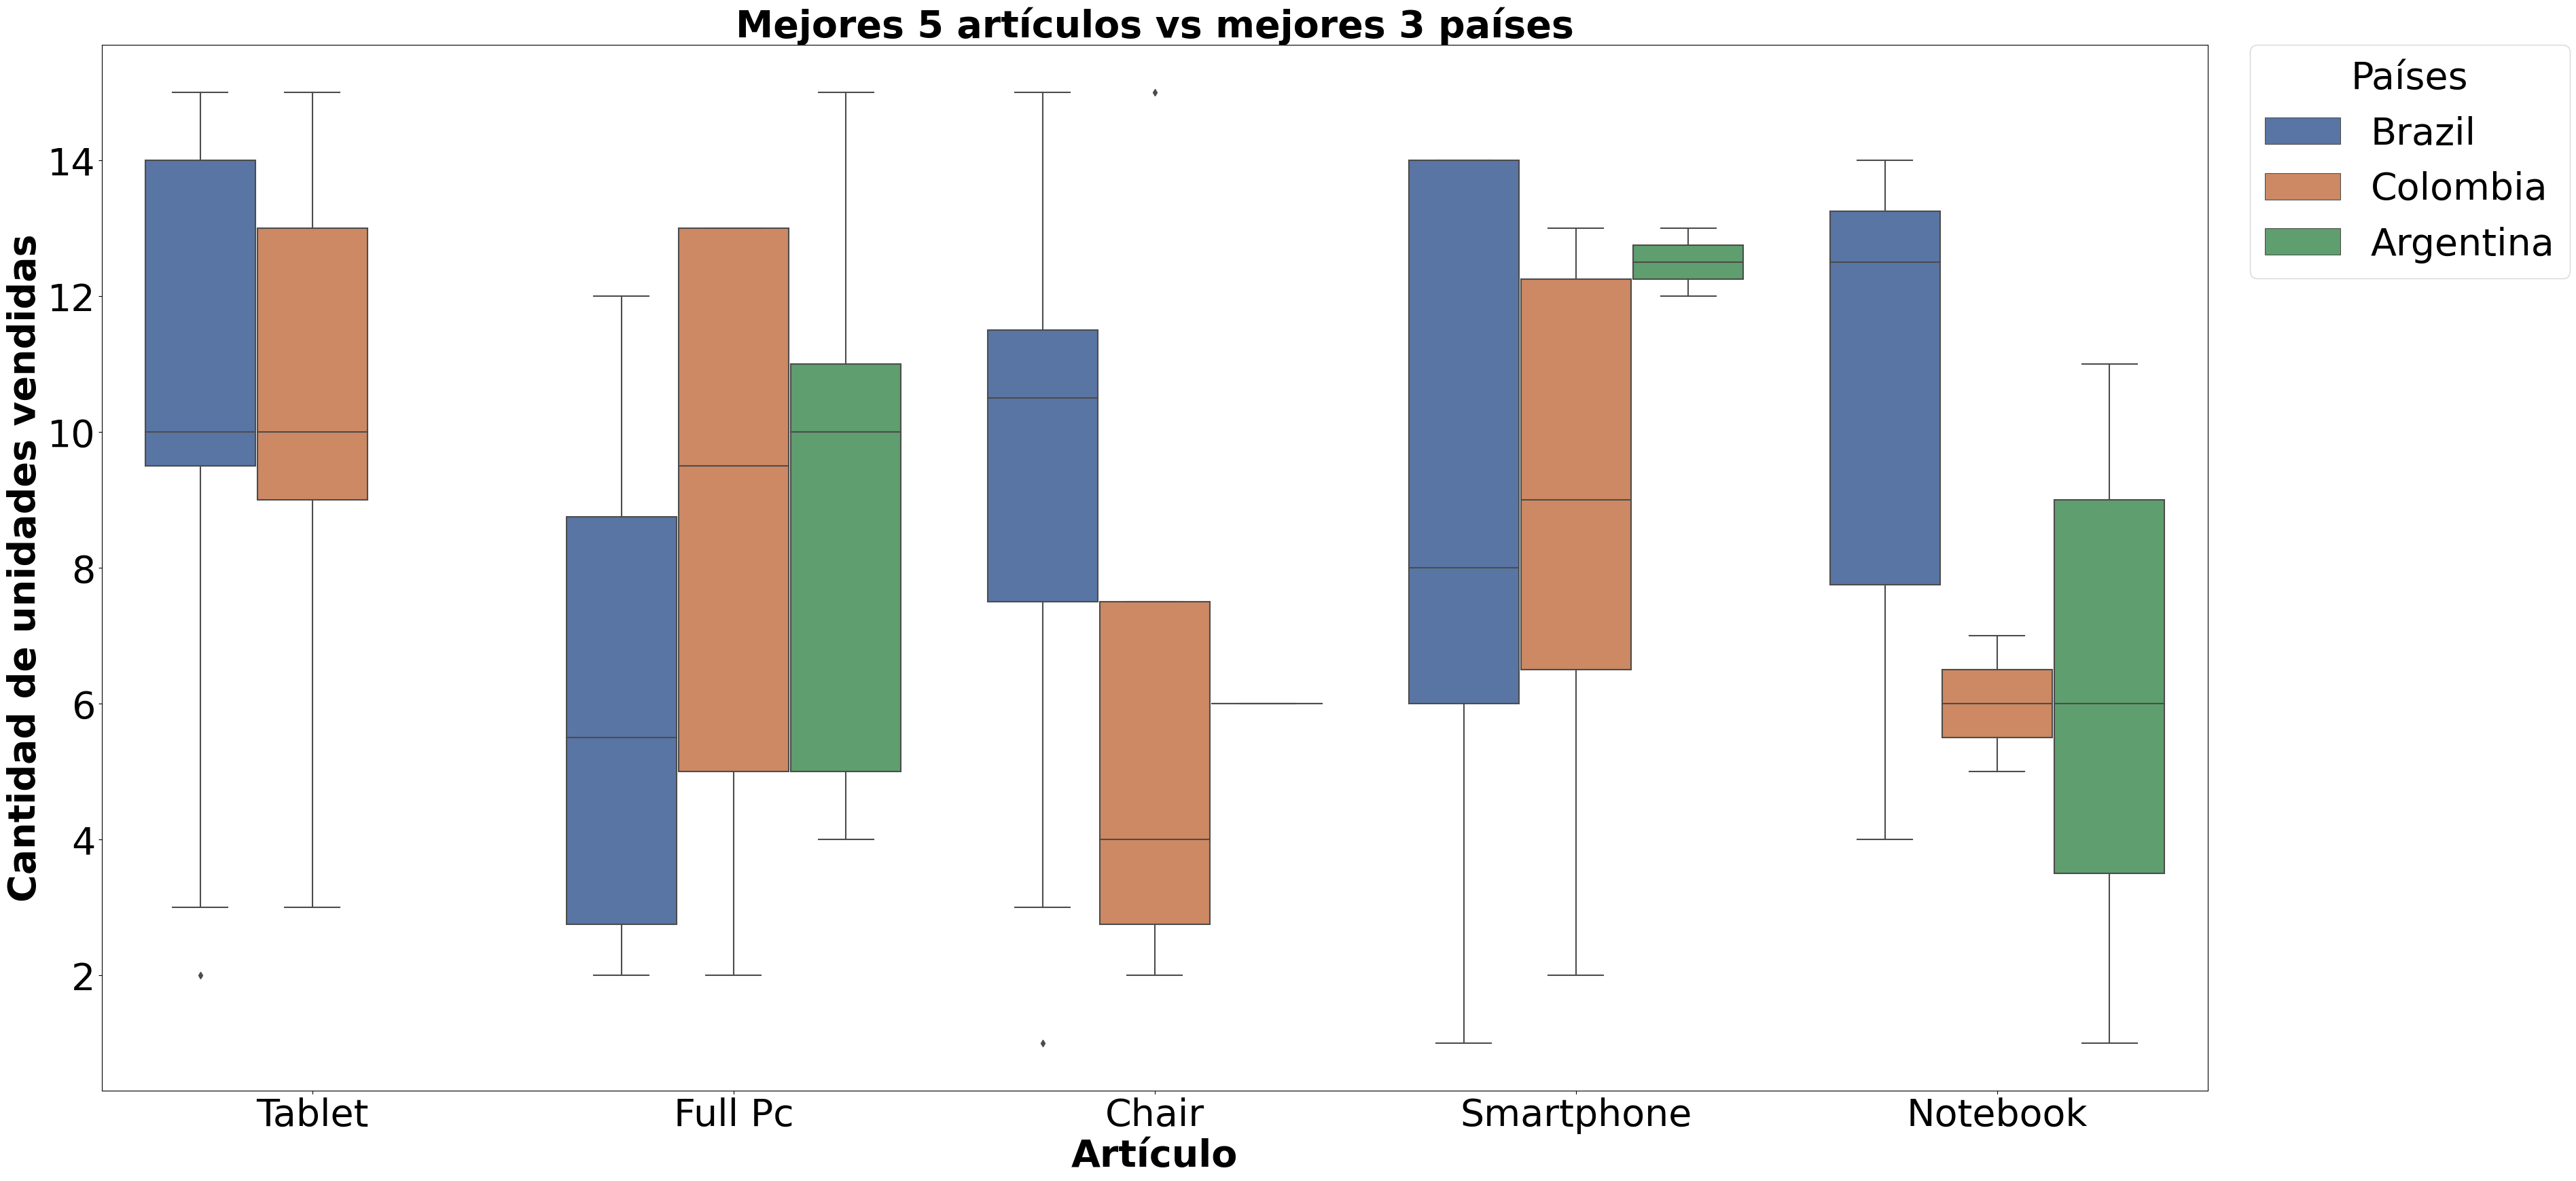

In [21]:
#Resolución Gráfica
fig, ax = plt.subplots(figsize=(40,20))
sns.boxplot(data= df7, x= 'article_name', y = 'quantity', hue= 'country_name', dodge=True, palette='deep', ax=ax)
plt.title('Mejores 5 artículos vs mejores 3 países', fontsize=40, fontweight='bold') #Título

#Labels
plt.xlabel('Artículo', fontsize=40, fontweight='bold')
plt.ylabel('Cantidad de unidades vendidas', fontsize=40, fontweight='bold')

#Agrandar
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

#Localiza las legendas por fuera del gráfico
plt.legend(title='Países',bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=40)
plt.setp(ax.get_legend().get_title(), fontsize='40') #Para el título de la legenda

plt.show()

<h3>7. Variaciones de las ventas en el mes de los mejores 3 países </h3>

In [22]:
#Resolución analítica
países = df6.index.values[:3] #Mejores 3 países, obtuvido del dataframe de mejores países
df8 = my_df.groupby(['country_name', 'week']).sum() #Pone de indice una tupla país y semana
df8 = df8.reset_index() #Pasa los índices a columnas

#Elimino las filas que contengan países que no me interesan analizar
for i in range(len(df8.index)):
    if df8.loc[i,'country_name'] not in países:
        df8 = df8.drop([i])

#Elimino la columna 'quantity'
df8 = df8.drop(columns='quantity')
print(df8)

   country_name  week  total_amount
0     Argentina     1      63760.48
1     Argentina     2      96789.13
2     Argentina     3      26601.97
3     Argentina     4      18681.20
8        Brazil     1     165289.90
9        Brazil     2     106803.85
10       Brazil     3      79341.50
11       Brazil     4      89836.60
16     Colombia     1      38399.41
17     Colombia     2      40471.92
18     Colombia     3      69473.90
19     Colombia     4      29169.06


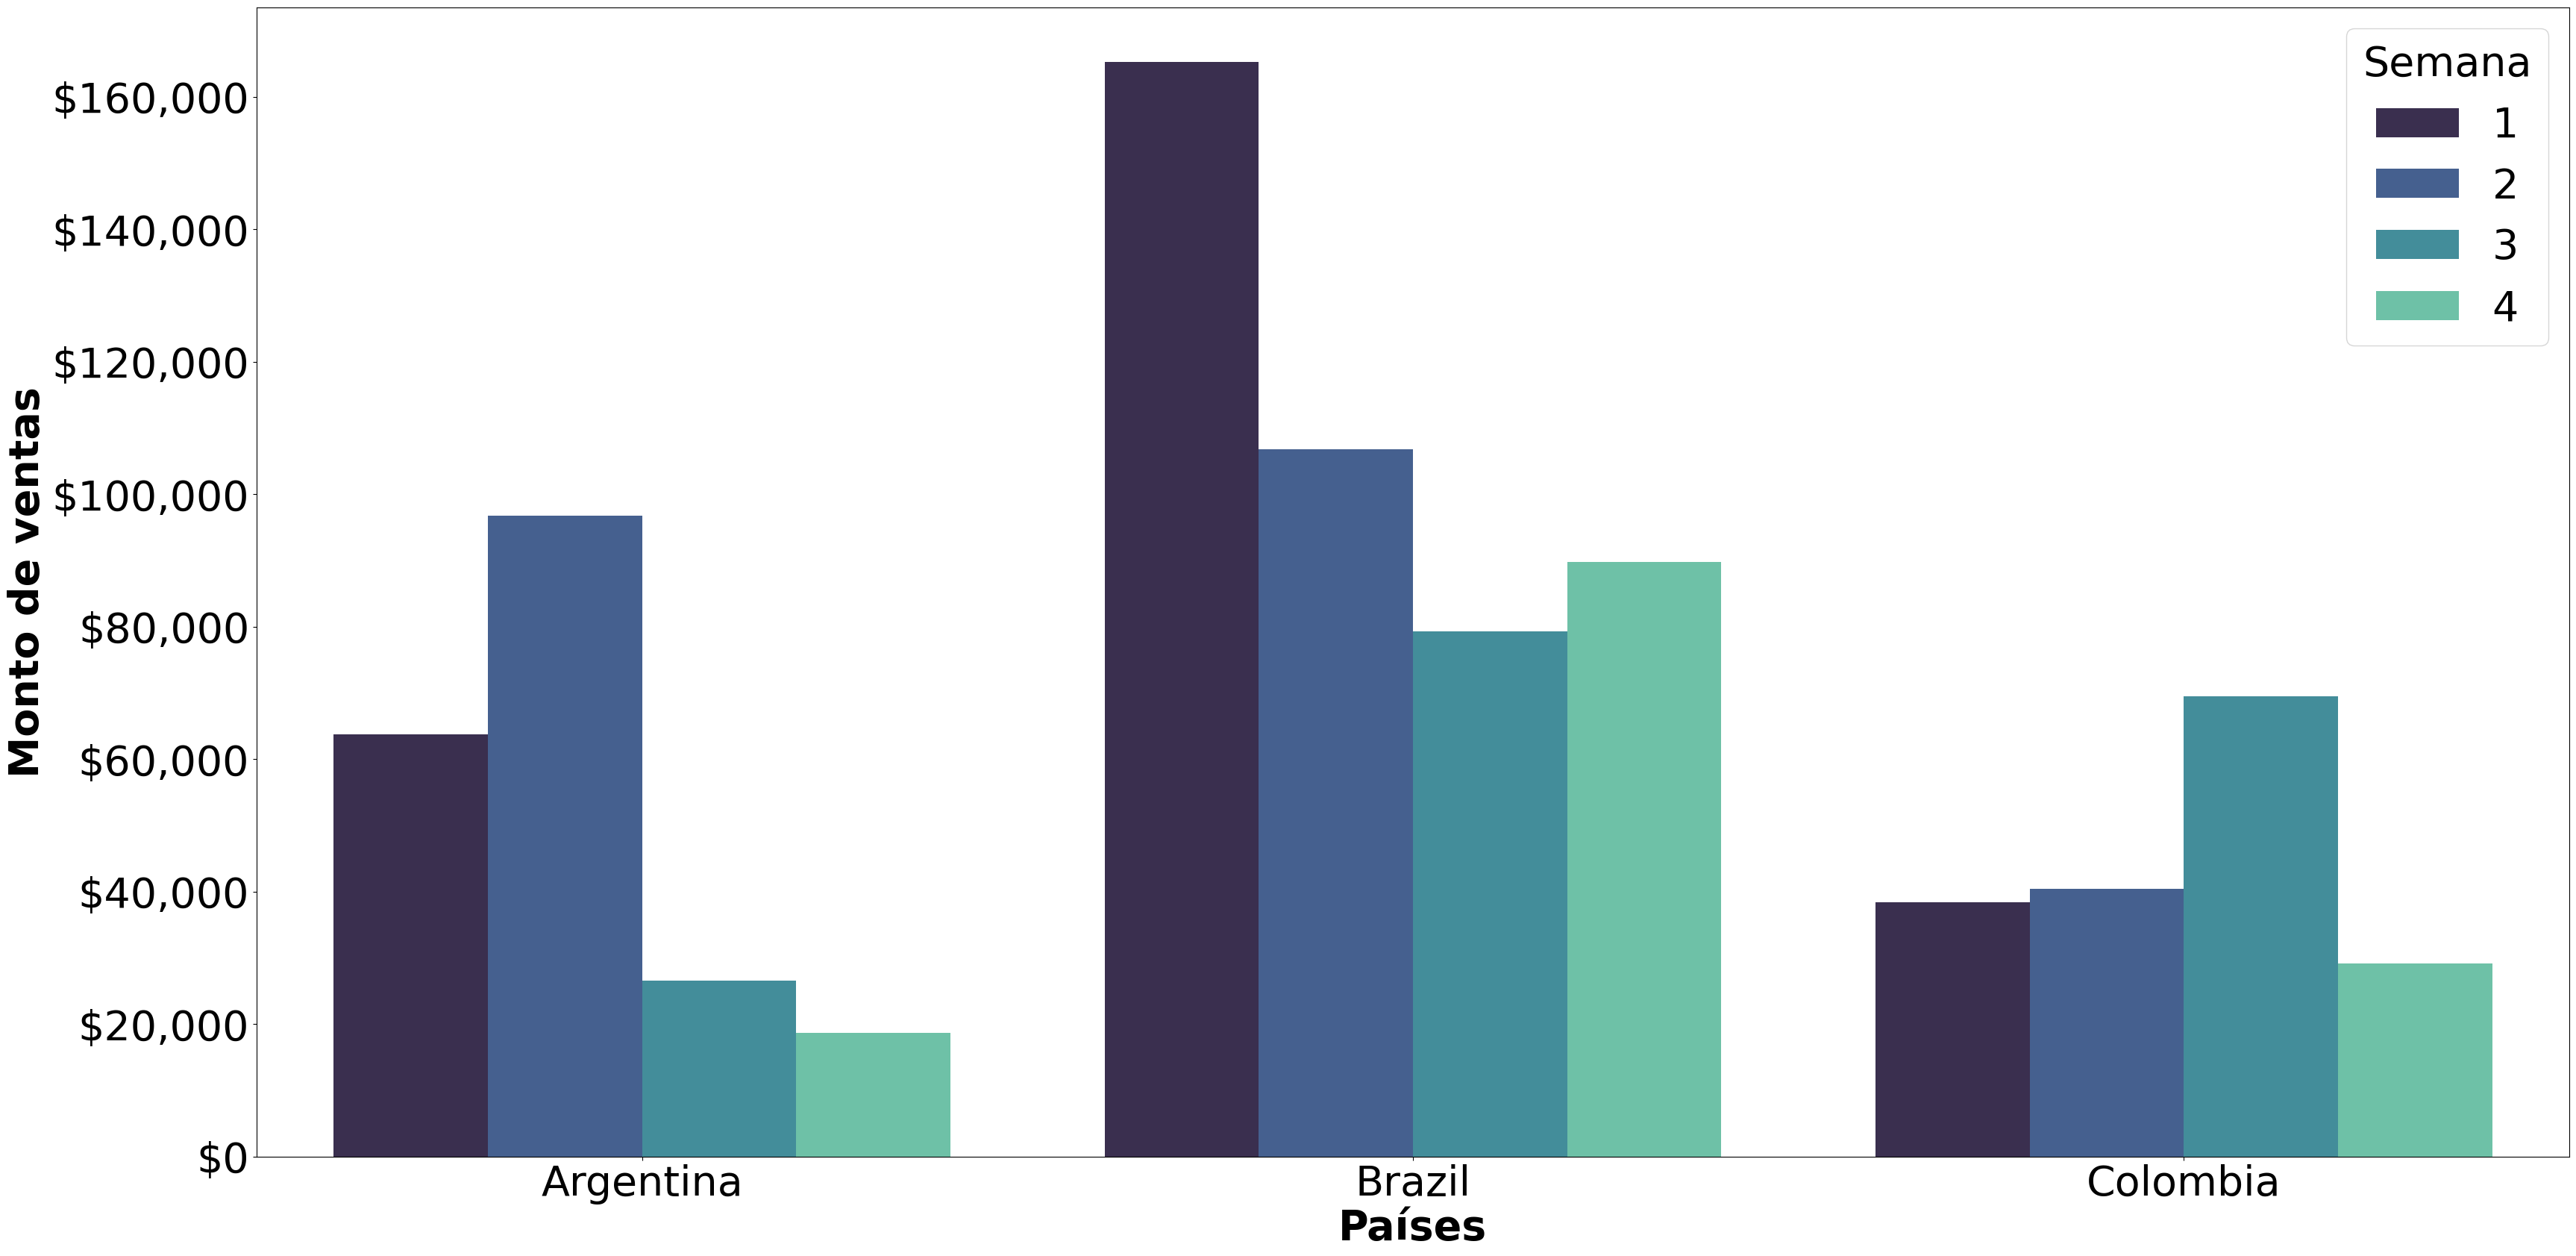

In [23]:
#Resolución gráfica
fig, ax = plt.subplots(figsize=(40,20))
sns.barplot(data= df8, x= 'country_name', y = 'total_amount', hue= 'week', dodge=True, palette='mako', ax=ax)

#Setear el signo $ en el eje Y
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#Agrandar
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#Labels
plt.xlabel('Países', fontsize=40, fontweight='bold')
plt.ylabel('Monto de ventas', fontsize=40, fontweight='bold')
plt.legend(title='Semana', fontsize=40)
plt.setp(ax.get_legend().get_title(), fontsize='40') #Para el título de la legenda

plt.show()

<h2>Conclusiones y propuestas</h2>
<p> <FONT SIZE=4> <b> Pregunta 1: </b> El artículo que más cantidad vendió fue la HDD, más del doble que el que menos vendío, el cual fue la wifi-car.
Si uno quiere incentivar ventas por unidad deberá considerar una promoción más fuerte y eficaz para las de menor venta.Un dato curioso obtenido a partir de esta resolución es la cantidad de ventas de mouse (unas 320, aproximadamente) 
</font> </p>
<br>  <!Salto de línea>

<p> <FONT SIZE=4> <b> Pregunta 2: </b> El artículo que generó más ingreso fue la full pc, probablemente por el coste elevado de la misma  y la utilidad que uno le puede sacar a ese artículo. Luego le siguen otro artículos completos a nivel tecnológico como son las notebooks y smartphones</font> </p>
<br>

<p> <FONT SIZE=4> <b> Pregunta 3: </b>  Janel O'curran destaca dentro de los empleados del mes, habría que considerar darle un bono por los resultados obtenido </font> </p>
<br>

<p> <FONT SIZE=4> <b> Pregunta 4: </b> Las variaciones a lo largo del mes son notorias, van decayendo a nivel que avanza el mes, probablemente se deba a que la gente compra ni bien recibe su sueldo y para las últimas semanas se cuida el bolsillo. En líneas generales se podría hacer una campaña promoción para la cuarta semana de ventas, la cual es la que menor aporte genera</font> </p> </font> </p>
<br>

<p> <FONT SIZE=4> <b> Pregunta 5: </b> Brasil es por gran diferencia el más contribuyente a nivel plata, habría que hacer un detalle más en profundidad por zonas dentro de Brasil para así considerar si abrir otro local (o no) y dónde. Por otro lado, habría que analizar el monto de ventas por país comparado con su población, no es lo mismo Brasil que Uruguay</font> </p>
<br>

<p> <FONT SIZE=4> <b> Pregunta 6: </b> Hay que notar que Argentina tiene un compartamiento raro con respecto a los mejores artículos, las órdenes de cantidad de Full Pc y Notebooks son variadas, mientras que en el resto de artículos no compra mucho o casi siempre la misma cantidad. Habría que fijarse qué pasa con esos artículos, si se suelen vender o no.</font> </p>
<br>

<p> <FONT SIZE=4> <b> Pregunta 7: </b> Analizando estos 3 mejores países uno puede ver que la tendencia a lo largo del mes tiende a bajar, a excepción de Colombia que en la tercera semana logra su mayor recaudación. Se recalca la propuesta de una campaña de promoción para la cuarta semana.
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d6184b2a-f349-406f-adc8-df2039bd5ffc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>